# Scene Property Ratings

In [227]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats
import random


In [228]:
def combineCSVs(datafolder, num_discrim_trials):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    
    returns:
        (1) combined dataframe of all discrimination data 
        (2) combined dataframe of all scene property rating data 
    """
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        discrim_data = []
        properties_data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                
                df_discrim = df[0:num_discrim_trials]
                discrim_data.append(df_discrim)
                # row 96 should be ignored - artifact of logging 
                df_properties = df[num_discrim_trials+1:]
                properties_data.append(df_properties)
                

        discrim_frame = pd.concat(discrim_data, axis=0, ignore_index=True)
        properties_frame = pd.concat(properties_data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            df = pd.read_csv(datafolder, index_col=None, header=0)
            df_discrim = df[0:num_discrim_trials]
            discrim_data.append(df_discrim)
            # row 96 should be ignored - artifact of logging 
            df_properties = df[num_discrim_trials+1:]
            properties_data.append(df_properties)
 
    return discrim_frame, properties_frame

In [229]:
data_path = '/Users/prachi/Documents/depth_duration/depth_discrimination/v4_discrim_pilot_data'

In [230]:
raw_discrim, raw_ratings = combineCSVs(data_path, 96)

In [231]:
raw_ratings

,subjID,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,screenWidth,screenHeight,...,log_sceneDuration2,log_mask2,unitSelection,meanDepth_rating,navigability_rating,rated_stimulus,rating_RT,experimentTime,totalTime,age
0,570118,DepthScenes,duration_discrimination,discrim_jsons/d0_rotated.json,http://54.197.185.130/DepthDuration/depth_disc...,3,1499,853,1366,768,...,204,507,feet,4.0,3.0,depth_discrimination_stimuli/002660_2014-06-13...,9479.0,1566550,1996574,56
1,570118,DepthScenes,duration_discrimination,discrim_jsons/d0_rotated.json,http://54.197.185.130/DepthDuration/depth_disc...,3,1499,853,1366,768,...,204,507,feet,5.0,4.0,depth_discrimination_stimuli/003490_2014-05-21...,12857.0,1566550,1996574,56
2,570118,DepthScenes,duration_discrimination,discrim_jsons/d0_rotated.json,http://54.197.185.130/DepthDuration/depth_disc...,3,1499,853,1366,768,...,204,507,feet,4.0,2.0,depth_discrimination_stimuli/003288_2014-05-14...,7557.0,1566550,1996574,56
3,570118,DepthScenes,duration_discrimination,discrim_jsons/d0_rotated.json,http://54.197.185.130/DepthDuration/depth_disc...,3,1499,853,1366,768,...,204,507,feet,5.0,2.0,depth_discrimination_stimuli/002964_2014-06-08...,6607.0,1566550,1996574,56
4,570118,DepthScenes,duration_discrimination,discrim_jsons/d0_rotated.json,http://54.197.185.130/DepthDuration/depth_disc...,3,1499,853,1366,768,...,204,507,feet,4.0,3.0,depth_discrimination_stimuli/001584_2014-06-20...,5892.0,1566550,1996574,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4307,361608,DepthScenes,duration_discrimination,discrim_jsons/d0_rotated_dr.json,http://54.197.185.130/DepthDuration/depth_disc...,2,1349,768,1366,768,...,235,515,feet,2.0,1.0,depth_discrimination_stimuli/002305_2014-06-28...,2981.0,1353107,1698388,49
4308,361608,DepthScenes,duration_discrimination,discrim_jsons/d0_rotated_dr.json,http://54.197.185.130/DepthDuration/depth_disc...,2,1349,768,1366,768,...,235,515,feet,3.0,4.0,depth_discrimination_stimuli/000691_2014-06-08...,6900.0,1353107,1698388,49
4309,361608,DepthScenes,duration_discrimination,discrim_jsons/d0_rotated_dr.json,http://54.197.185.130/DepthDuration/depth_disc...,2,1349,768,1366,768,...,235,515,feet,2.0,3.0,depth_discrimination_stimuli/001571_2014-06-20...,5198.0,1353107,1698388,49
4310,361608,DepthScenes,duration_discrimination,discrim_jsons/d0_rotated_dr.json,http://54.197.185.130/DepthDuration/depth_disc...,2,1349,768,1366,768,...,235,515,feet,3.0,2.0,depth_discrimination_stimuli/002043_2014-06-24...,4844.0,1353107,1698388,49


In [232]:
def catchTrial_cleaning(df, allowed_incorrect, catch_stimuli):
    '''
    Participants complete 4 catch trials total to ensure that they are doing the task.
    If 3 or more trials are incorrect, the participant is excluded.  
    '''
    all_subjIDs = df.subjID.unique()
    remove = []
    df2_list = []
    for subj in all_subjIDs:
        count_incorrect = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning
        
        # remove trials that are outside the outlier range
        for idx, row in subj_df.iterrows():
            stim = row['rated_stimulus']
            if stim.split('/')[1] in list(catch_stimuli.keys()):
                md_response = row['meanDepth_rating']
                nav_response = row['navigability_rating']
                
                ans = catch_stimuli[stim.split('/')[1]]
                if ans[0] == 'm':
                    if ans[1] == 1:
                        valid_ratings = 2 # highest acceptable response is 2
                        if md_response > valid_ratings:
                            count_incorrect += 1
                            print(md_response, nav_response, ans)

                            
                    if ans[1] == 5:
                        valid_ratings = 4 # lowest acceptable response is 4
                        if md_response < valid_ratings:
                            count_incorrect += 1
                            print(md_response, nav_response, ans)
                        
                if ans[0] == 'n':
                    if ans[1] == 1:
                        valid_ratings = 2 # highest acceptable response is 2
                        if nav_response > valid_ratings:
                            count_incorrect += 1
                            print(md_response, nav_response, ans)
                            
                    if ans[1] == 5:
                        valid_ratings = 4 # lowest acceptable response is 4
                        if nav_response < valid_ratings:
                            count_incorrect += 1
                            print(md_response, nav_response, ans)
                        
        if count_incorrect > allowed_incorrect:
            remove.append(subj)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print("Number of participants that did not pass the catch trial check:", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2

In [233]:
# Mean depth: 1 low, 1 high

# High: /Users/prachi/Documents/MeanDepthAdaptation_Stimuli/high_pole/sun_aatxlublfjchvvzu.jpg
# Low: /Users/prachi/Documents/MeanDepthAdaptation_Stimuli/low_pole/000675_2014-06-08_22-59-18_260595134347_rgbf000096-resize.jpg

# Navigability: 1 low, 1 high

# High: /Users/prachi/Documents/MeanDepthAdaptation_Stimuli/high_pole/sun_aoquhiddlfqapdlz.jpg
# Low: /Users/prachi/Documents/MeanDepthAdaptation_Stimuli/low_pole/sun_bpzzatthlcapxzol.jpg

all_catch_stim = {'000675_2014-06-08_22-59-18_260595134347_rgbf000096-resize.jpg': ('m',1),
                  'sun_aatxlublfjchvvzu.jpg': ('m',5),
                  'sun_aoquhiddlfqapdlz.jpg': ('n',5),
                  'sun_bpzzatthlcapxzol.jpg': ('n',1)}


In [234]:
cleaned_ratings = catchTrial_cleaning(raw_ratings, 1 , all_catch_stim)

4.0 1.0 ('m', 1)
3.0 5.0 ('m', 5)
2.0 3.0 ('n', 1)
3.0 4.0 ('m', 1)
4.0 3.0 ('n', 1)
2.0 5.0 ('m', 5)
5.0 1.0 ('m', 1)
3.0 3.0 ('n', 1)
3.0 2.0 ('m', 5)
3.0 2.0 ('m', 1)
3.0 5.0 ('n', 1)
3.0 2.0 ('m', 1)
1.0 3.0 ('m', 5)
4.0 3.0 ('n', 1)
3.0 2.0 ('m', 1)
3.0 3.0 ('n', 1)
3.0 2.0 ('m', 1)
5.0 3.0 ('n', 1)
3.0 2.0 ('m', 1)
2.0 3.0 ('n', 5)
1.0 2.0 ('m', 5)
5.0 4.0 ('n', 1)
4.0 3.0 ('n', 5)
3.0 4.0 ('m', 1)
2.0 3.0 ('n', 1)
3.0 3.0 ('m', 1)
2.0 3.0 ('n', 1)
3.0 5.0 ('m', 1)
2.0 5.0 ('m', 5)
2.0 2.0 ('n', 5)
2.0 3.0 ('n', 1)
5.0 1.0 ('n', 5)
2.0 3.0 ('n', 1)
Number of participants that did not pass the catch trial check: 10


In [235]:
def get_mean_depth_ratings(df):
    all_stimuli = df.rated_stimulus.unique()
    
    stim_meanDepth_rating = {}
    for stim in all_stimuli:
        stim_df = df.loc[df['rated_stimulus'] == stim]
        stim_meanDepth_rating[stim] = list(stim_df['meanDepth_rating'])

    return stim_meanDepth_rating
        
def get_navigability_ratings(df):
    all_stimuli = df.rated_stimulus.unique()
    
    stim_meanDepth_rating = {}
    for stim in all_stimuli:
        stim_df = df.loc[df['rated_stimulus'] == stim]
        stim_meanDepth_rating[stim] = list(stim_df['navigability_rating'])

    return stim_meanDepth_rating
     

In [236]:
mean_depth_ratings = get_mean_depth_ratings(cleaned_ratings)


In [237]:
navigability_ratings = get_navigability_ratings(cleaned_ratings)

In [238]:
# get avg and std for each stimulus

stimulus_mean_depth_stats = {}
meandepth_avgs = [] 
meandepth_std = []
for stim in mean_depth_ratings:
    stimulus_mean_depth_stats[stim] = [np.mean(np.array(mean_depth_ratings[stim])), np.std(np.array(mean_depth_ratings[stim]))]
    meandepth_avgs.append(np.mean(np.array(mean_depth_ratings[stim])))
    if np.std(np.array(mean_depth_ratings[stim])) < 0.5:
        print(stim, np.mean(np.array(mean_depth_ratings[stim])))
    meandepth_std.append(np.std(np.array(mean_depth_ratings[stim])))
    

depth_discrimination_stimuli/002365_2014-06-28_20-11-21_260595134347_rgbf000102-resize_1/002365_2014-06-28_20-11-21_260595134347_rgbf000102-resize-original.jpg 2.9166666666666665
depth_discrimination_stimuli/001150_2014-06-17_15-27-34_260595134347_rgbf000108-resize_2/001150_2014-06-17_15-27-34_260595134347_rgbf000108-resize-original.jpg 2.5833333333333335
depth_discrimination_stimuli/000780_2014-06-08_22-28-29_260595134347_rgbf000126-resize_1/000780_2014-06-08_22-28-29_260595134347_rgbf000126-resize-original.jpg 2.6666666666666665
depth_discrimination_stimuli/000929_2014-06-09_16-33-19_260595134347_rgbf000139-resize_0/000929_2014-06-09_16-33-19_260595134347_rgbf000139-resize-original.jpg 2.5833333333333335
depth_discrimination_stimuli/000800_2014-06-08_22-42-09_260595134347_rgbf000095-resize_3/000800_2014-06-08_22-42-09_260595134347_rgbf000095-resize-original.jpg 2.5833333333333335
depth_discrimination_stimuli/000830_2014-06-04_19-49-31_260595134347_rgbf000096-resize_2/000830_2014-06-0

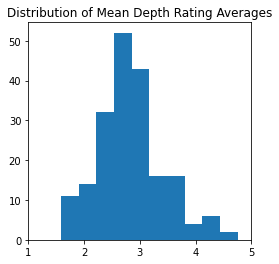

In [239]:
plt.figure(figsize=[4,4])
plt.hist(meandepth_avgs)
plt.xlim([1,5])
plt.title('Distribution of Mean Depth Rating Averages')
plt.show()

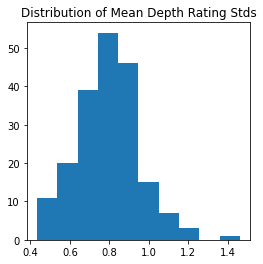

In [240]:
plt.figure(figsize=[4,4])
plt.hist(meandepth_std)
plt.title('Distribution of Mean Depth Rating Stds')
plt.show()

In [241]:
stimulus_navigability_stats = {}
navigability_avgs = [] 
navigability_std = []
for stim in navigability_ratings:
    stimulus_navigability_stats[stim] = [np.mean(np.array(navigability_ratings[stim])), np.std(np.array(navigability_ratings[stim]))]
    navigability_avgs.append(np.mean(np.array(navigability_ratings[stim])))
    navigability_std.append(np.std(np.array(navigability_ratings[stim])))

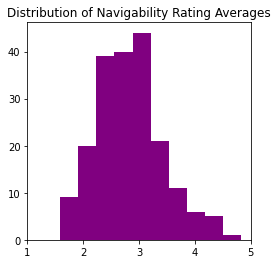

In [242]:
plt.figure(figsize=[4,4])
plt.hist(navigability_avgs, color='purple')
plt.xlim([1,5])
plt.title('Distribution of Navigability Rating Averages')
plt.show()

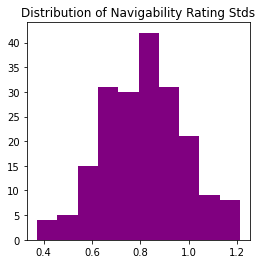

In [243]:
plt.figure(figsize=[4,4])
plt.hist(navigability_std, color='purple')
plt.title('Distribution of Navigability Rating Stds')
plt.show()

split participants w all stim 

mean and std within a scene 

outlier/exclusion: 
catch trials
- for mean depth and navigability 

log RT 

num of unique responses 


In [244]:
def get_participant_ratings(df):
    '''
    Returns list of participant rating lists 
    '''
    md_ratings = []
    nav_ratings = []
    all_subjects = df.subjID.unique()
    for subj in all_subjects:
        subj_df = df.loc[df['subjID'] == subj]
        subj_meandepth_ratings = list(subj_df['meanDepth_rating'])
        subj_navigability_ratings = list(subj_df['navigability_rating'])
        
        md_ratings.append(subj_meandepth_ratings)
        nav_ratings.append(subj_navigability_ratings)
    
    
    return md_ratings, nav_ratings

In [245]:
subjects_meanDepth_ratings, subjects_navigability_ratings = get_participant_ratings(raw_ratings)

In [246]:
len(subjects_navigability_ratings[8])

196

## Calculate Split Half Correlations 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html



In [247]:
def split_correlations(ratings, num_splits):
    num_subj = len(ratings)
    split_corrs = []
    split_spearmanr = []
    for i in range(num_splits):
        split1 = []
        split2 = []
        random.shuffle(ratings)
        if i % 2 == 0:
            split1 = ratings[0:num_subj//2]
            split2 = ratings[num_subj//2:(num_subj//2)*2]
        else:
            split2 = ratings[0:num_subj//2]
            split1 = ratings[num_subj//2:(num_subj//2)*2]
        
        print(type(split1[0][0]), split2)
        corr = scipy.stats.pearsonr(split1, split2)
        spearmanr = stats.spearmanr(split1, split2)
        split_corrs.append(corr)
        split_spearmanr.append(spearmanr)
        
    return np.mean(np.array(split_corrs)), np.mean(np.array(split_spearmanr))
        

In [248]:
md_split_corr_100 = split_correlations(subjects_meanDepth_ratings, 2)

<class 'float'> [[3.0, 4.0, 4.0, 3.0, 4.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0, 3.0, 3.0, 3.0, 4.0, 4.0, 2.0, 3.0, 1.0, 4.0, 3.0, 2.0, 3.0, 3.0, 3.0, 4.0, 5.0, 4.0, 4.0, 3.0, 4.0, 3.0, 3.0, 2.0, 4.0, 3.0, 2.0, 4.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 3.0, 4.0, 4.0, 4.0, 4.0, 3.0, 3.0, 3.0, 4.0, 3.0, 4.0, 4.0, 2.0, 3.0, 3.0, 4.0, 3.0, 4.0, 3.0, 3.0, 4.0, 3.0, 3.0, 4.0, 2.0, 3.0, 5.0, 2.0, 3.0, 3.0, 5.0, 3.0, 3.0, 4.0, 3.0, 3.0, 3.0, 5.0, 3.0, 4.0, 4.0, 3.0, 2.0, 3.0, 4.0, 3.0, 4.0, 3.0, 2.0, 3.0, 4.0, 3.0, 4.0, 4.0, 3.0, 5.0, 4.0, 4.0, 5.0, 3.0, 3.0, 4.0, 5.0, 4.0, 3.0, 3.0, 4.0, 5.0, 3.0, 4.0, 3.0, 3.0, 4.0, 3.0, 5.0, 3.0, 5.0, 4.0, 4.0, 4.0, 4.0, 3.0, 2.0, 3.0, 2.0, 4.0, 4.0, 2.0, 3.0, 4.0, 2.0, 5.0, 4.0, 3.0, 4.0, 3.0, 2.0, 3.0, 4.0, 3.0, 4.0, 4.0, 3.0, 5.0, 3.0, 4.0, 4.0, 4.0, 2.0, 3.0, 4.0, 3.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 3.0, 3.0, 4.0, 3.0, 3.0, 4.0, 4.0, 3.0, 4.0, 3.0, 3.0, 4.0, 4.0, 3.0, 4.0, 4.0, 3.0, 3.0, 5.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0], [

TypeError: No loop matching the specified signature and casting was found for ufunc add

In [117]:
x = [[1,2,3], [2, 3, 4], [4, 5, 6], [5, 6, 7], [6, 7, 8]]
s1 = np.array(x[0:len(x)//2])
s2 = np.array(x[len(x)//2:(len(x)//2)*2])
scipy.stats.pearsonr(s1, s2)

(array([[[1.]]]), 1.0)

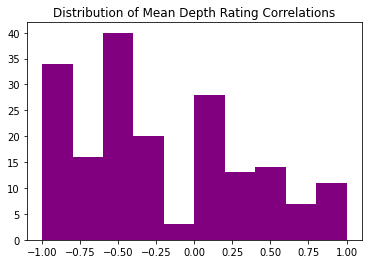

In [15]:
plt.figure()
plt.hist(mean_depth_corr_distributions, color='purple')
plt.title('Distribution of Mean Depth Rating Correlations')
plt.show();

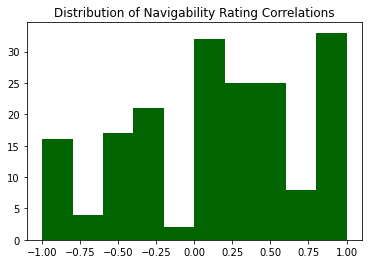

In [91]:
plt.figure()
plt.hist(navigability_corr_distributions, color='darkgreen')
plt.title('Distribution of Navigability Rating Correlations')
plt.show();